In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_sales = pd.read_csv("Electric_Production.csv")

In [3]:
df_sales.head()

,DATE,Value
0,01-01-1985,72.5052
1,02-01-1985,70.6720
2,03-01-1985,62.4502
3,04-01-1985,57.4714
4,05-01-1985,55.3151


## Let us set datetime index

In [4]:
df_sales['DATE'] = pd.to_datetime(df_sales['DATE'])

In [6]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    397 non-null    datetime64[ns]
 1   Value   397 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.3 KB


In [7]:
df_sales.shape

(397, 2)

### No null values in the data set
- Date time converted to index column

In [9]:
df_sales.set_index("DATE",inplace=True)
df_sales.head()

,Value
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


### Let us visualize the sales history



Text(0, 0.5, 'Sales')

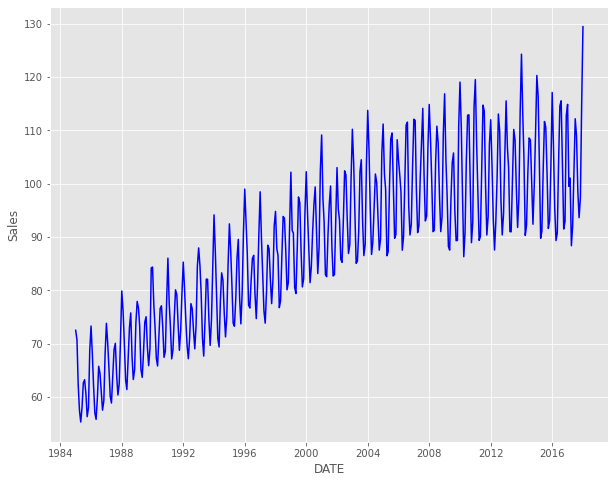

In [15]:
plt.style.use("ggplot")
plt.figure(figsize=(10,8))
plt.plot(df_sales.index,df_sales['Value'],c='b')
plt.xlabel("DATE")
plt.ylabel("Sales")

### Let's install statsmodels packages 

In [76]:
from statsmodels.graphics.tsaplots import acf,pacf,plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

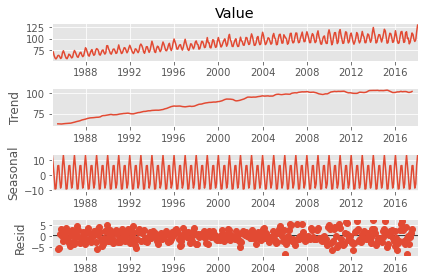

In [46]:
sales = df_sales['Value']
#plt.figure(figsize=(1,1))
metrics = seasonal_decompose(sales)
res = seasonal_decompose(sales).plot()


### We can use additive model here as residuals are very small
- There is a yealy seasonality

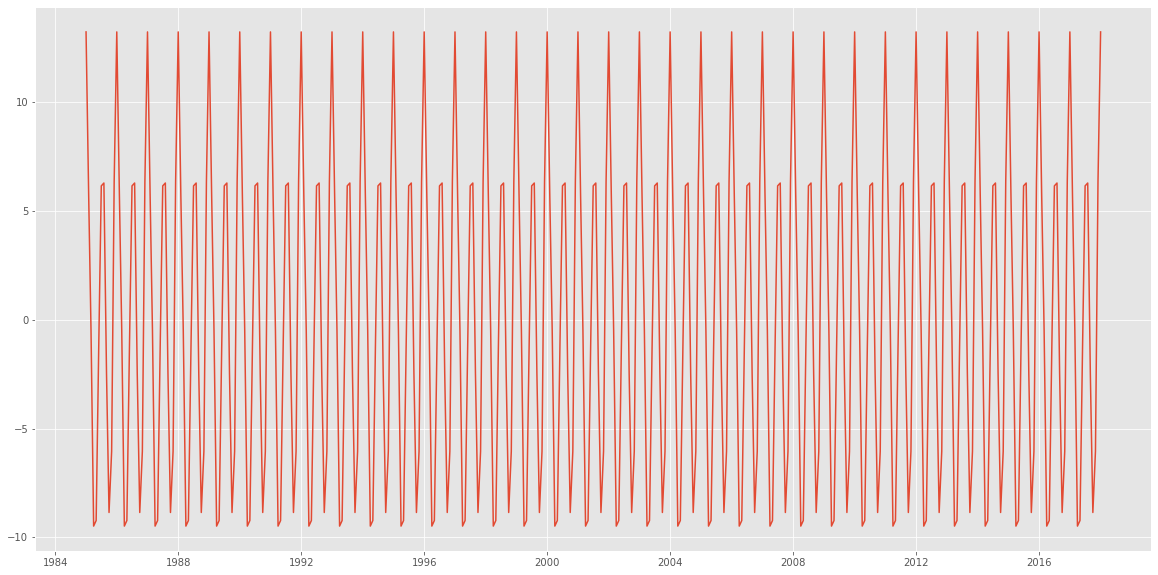

In [55]:
metrics.seasonal
plt.figure(figsize=(20,10))
plt.plot(metrics.seasonal.index,metrics.seasonal )

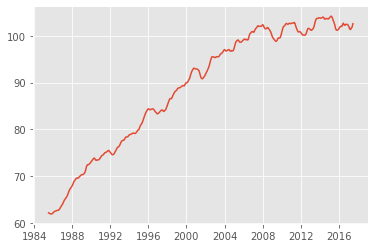

In [60]:
## Plotting the trend
plt.plot(metrics.trend.index,metrics.trend)

### Data looks to be stationary
- Let us perform dickyfuller test
- H0 - Data is not stationary
- H1 - Data is stationary

####  Test is
- if p-value > 0.05 then data is not stationary H0 accepted
- Else we reject H0 and say data is stationary


In [72]:
from statsmodels.tsa.stattools import adfuller


def dickyfuller_test(data):
    p_val = adfuller(data)[1]
    if p_val <= 0.05:
        print("data is Stationary")
    else:
        print("Data is non Stationary")
        
dickyfuller_test(df_sales['Value'])

Data is non Stationary


## There are 4 spikes in a batch of 4 years
- One spike every year
- The means the tata set is periodic with period(season) of one year

### Looking at the data there is an upward trend
- To make data stationary differencing should be done

In [68]:
df_sales["Diff1"] = df_sales["Value"].diff(1)

In [69]:
df_sales["Diff1"]

DATE
1985-01-01        NaN
1985-02-01    -1.8332
1985-03-01    -8.2218
1985-04-01    -4.9788
1985-05-01    -2.1563
               ...   
2017-09-01   -10.3158
2017-10-01    -5.0017
2017-11-01     3.7222
2017-12-01    17.3853
2018-01-01    14.6836
Name: Diff1, Length: 397, dtype: float64

<AxesSubplot:xlabel='DATE'>

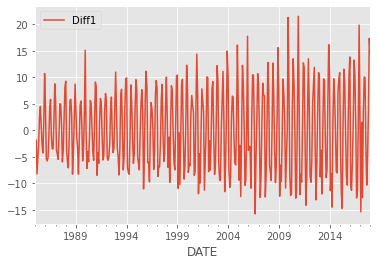

In [70]:
df_sales.plot(y="Diff1")

## Let us perform Dicky fuller test now

In [74]:
dickyfuller_test(df_sales['Diff1'].iloc[1:])

data is Stationary


### Normal Arima in not good on seasonal data

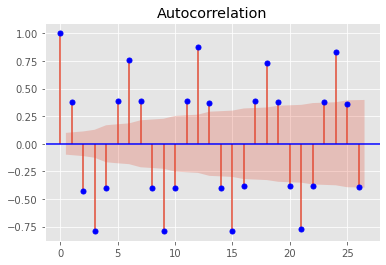

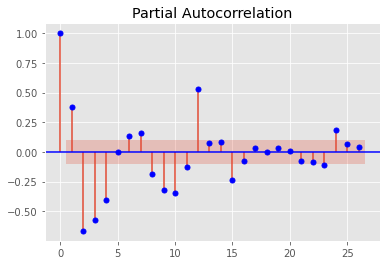

In [81]:
acf = plot_acf(df_sales['Diff1'].iloc[1:],c='b')
pacf = plot_pacf(df_sales['Diff1'].iloc[1:],c='b')

- ACF not getting close to `0` and pacf has geometric decay
- Choosing `P` and `Q` becomes difficult

#### Let us take a difference of 12

In [82]:
df_sales['Diff12'] = df_sales['Value'].diff(12)

### Let us check stationarity and plot acf and pacf

data is Stationary


<AxesSubplot:xlabel='DATE'>

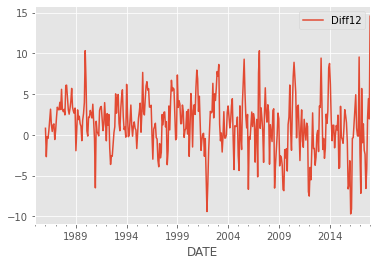

In [87]:
dickyfuller_test(df_sales.loc[~df_sales['Diff12'].isnull(),'Diff12'])

### Noe plot the data
df_sales.plot(y='Diff12')

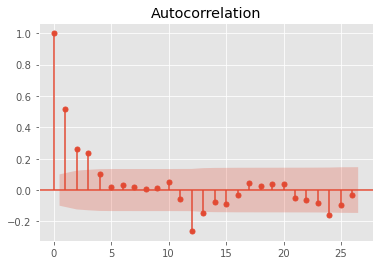

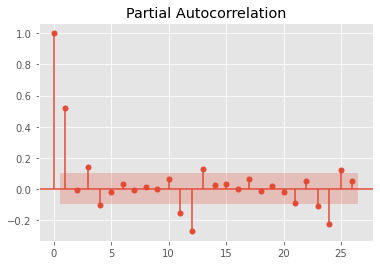

In [90]:
acf = plot_acf(df_sales['Diff12'].iloc[12:])
acf = plot_pacf(df_sales['Diff12'].iloc[12:])

### This is an AR model 
- Moving average terms becomes 0 since there is geometric decay in `acf`
- There are 2 significant lags in `pacf` plot
- p = 2
- d = 1 and 12 both to test
- q = 0 no moving average

In [117]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace import sarimax

In [122]:
model = ARIMA(df_sales['Value'],order = (2,1,0),trend='t').fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Value   No. Observations:                  397
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -1227.718
Date:                Wed, 13 Oct 2021   AIC                           2463.436
Time:                        13:52:18   BIC                           2479.362
Sample:                    01-01-1985   HQIC                          2469.745
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1279      0.275      0.465      0.642      -0.412       0.668
ar.L1          0.6226      0.037     16.895      0.000       0.550       0.695
ar.L2         -0.6682      0.037    -18.166      0.000      -0.740      -0.596
sigma2        28.7708      1.762     16.329      0.000      25.318      32.224
===================================================================================
Ljung-Box (L1) (Q):                  59.36   Jarque-Bera (JB):                70.31
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.06   Skew:                            -0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [136]:
start = df_sales.index[-48]
end = df_sales.index[-1]
exog = df_sales['Value'].iloc[-48:-1]
predictions = model.predict(start,end,exog=exog)

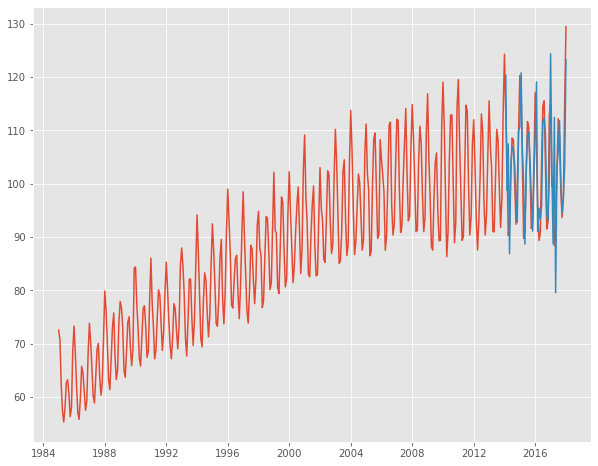

In [137]:
plt.figure(figsize=(10,8))
plt.plot(df_sales.index,df_sales['Value'])
plt.plot(predictions.index,predictions)

### It Is doing a good job
- Let us forecast for intermediate records

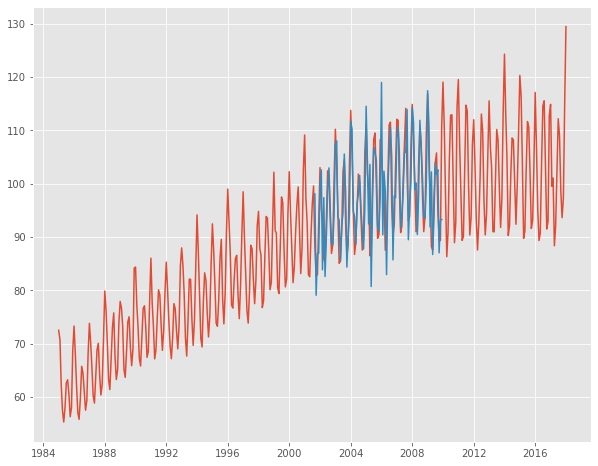

In [138]:
start = df_sales.index[200]
end = df_sales.index[299]
exog = df_sales['Value'].iloc[200:300]
predictions = model.predict(start,end,exog=exog)

plt.figure(figsize=(10,8))
plt.plot(df_sales.index,df_sales['Value'])
plt.plot(predictions.index,predictions)

### Looks like there is no seasonal effect but let us see for this estimates but let us cross check with difference of 12

In [147]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(df_sales['Value'],seasonal_order = (2,0,0,12),trend='t').fit()
model.summary()

C:\Users\1713958\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\1713958\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\1713958\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Value   No. Observations:                  397
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 12)   Log Likelihood                -995.407
Date:                            Wed, 13 Oct 2021   AIC                           2000.814
Time:                                    16:13:35   BIC                           2020.734
Sample:                                01-01-1985   HQIC                          2008.705
                                     - 01-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0023      0.001      3.824      0.000       0.001       0.003
ar.L1          0.7003      0.033     21.459      0.000       0.636       0.764
ar.S.L12       0.6352      0.039     16.151      0.000       0.558       0.712
ar.S.L24       0.3584      0.040      9.067      0.000       0.281       0.436
sigma2         7.7653      0.452     17.180      0.000       6.879       8.651
===================================================================================
Ljung-Box (L1) (Q):                   1.47   Jarque-Bera (JB):                38.28
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               2.56   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

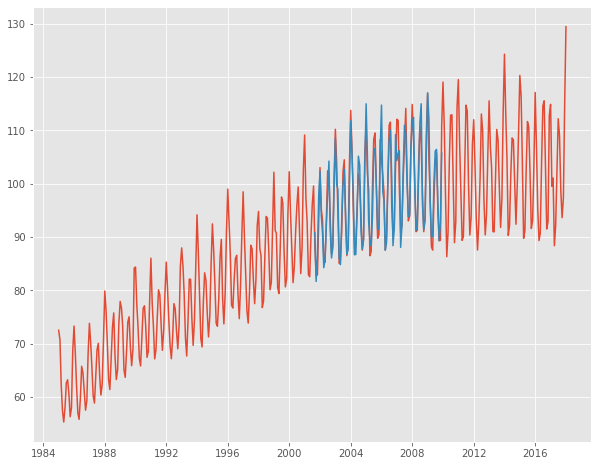

In [148]:
start = df_sales.index[200]
end = df_sales.index[299]
exog = df_sales['Value'].iloc[200:300]
predictions = model.predict(start,end,exog=exog)

plt.figure(figsize=(10,8))
plt.plot(df_sales.index,df_sales['Value'])
plt.plot(predictions.index,predictions)

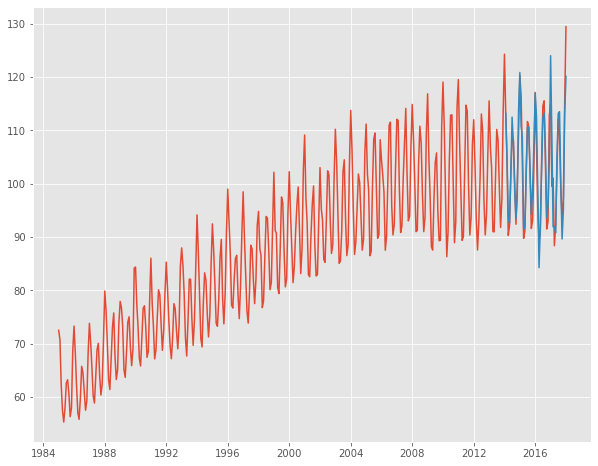

In [150]:
start = df_sales.index[-48]
end = df_sales.index[-1]
exog = df_sales['Value'].iloc[-48:]
predictions = model.predict(start,end,exog=exog)

plt.figure(figsize=(10,8))
plt.plot(df_sales.index,df_sales['Value'])
plt.plot(predictions.index,predictions)

### Now test on unseen data future

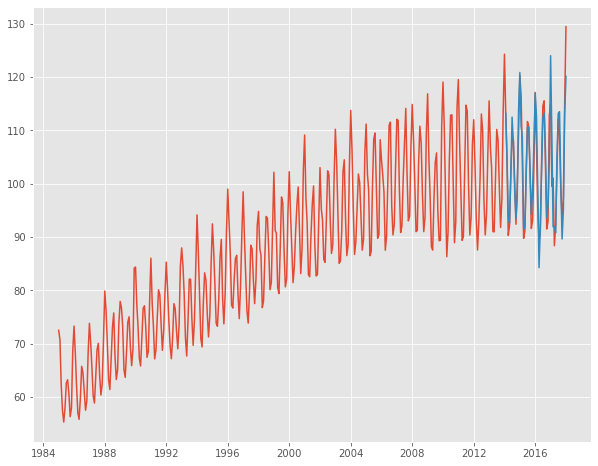

In [151]:

predictions = model.predict(start,end)

plt.figure(figsize=(10,8))
plt.plot(df_sales.index,df_sales['Value'])
plt.plot(predictions.index,predictions)

In [180]:
start =  max(df_sales.index)
end = start + pd.Timedelta(800,'D')
#dates = pd.date_range(start,end,freq='M')

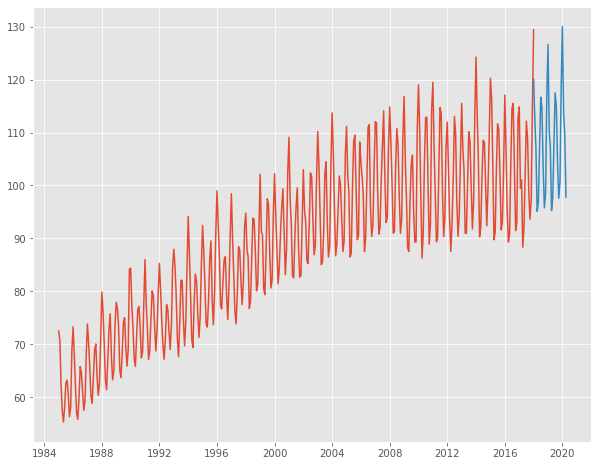

In [181]:

predictions = model.predict(start,end)

plt.figure(figsize=(10,8))
plt.plot(df_sales.index,df_sales['Value'])
plt.plot(predictions.index,predictions)

###  Predictions done on future
- SARIMAX - model because it was seasonal
- <a href="https://www.linkedin.com/pulse/reading-acf-pacf-plots-missing-manual-cheatsheet-saqib-ali">ACF and PACF plot trick</a>